# Import dataset

In [ ]:
import tensorflow as tf
import keras 
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
import cv2 as cv
import time

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras.models import Model


from tensorflow import keras
import tarfile
from shutil import copyfile

Collegamento a Google Drive il caricamento dei dati

https://www.kaggle.com/jehanbhathena/weather-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/My Drive/dataset.tar','dataset.tar')

tar= tarfile.open('dataset.tar')
tar.extractall()
tar.close()

In [ ]:
def load_foto():
    maximages = 600
    labels = []
    foto = []
    dir='/content/dataset/'
    for f in sorted(os.listdir(dir)):
      for k, im in enumerate(sorted(os.listdir(dir + f))):
        if f !='rainbow' and im.endswith('.jpg') and im not in [ "4514.jpg" , "1187.jpg"] and k <maximages: 
          img = cv.imread( dir + f + '/' + im)
          img = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)

          foto.append(img)
          label = f
          labels.append(label)
        
    X_train, X_test, y_train, y_test = train_test_split(foto, labels, test_size=0.2, random_state=1)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test=load_foto()

# Preprocessing

In [ ]:
# preprocessing sui dati

X_train_nuovo = np.array(X_train)
X_test_nuovo =np.array(X_test)


#rendo le labels categoriche
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_train_nuovo = np_utils.to_categorical(y_train_enc, 10)
y_test_enc = encoder.fit_transform(y_test)
y_test_nuovo = np_utils.to_categorical(y_test_enc, 10)

#rinomino
#X_train=X_train_nuovo
#X_test= X_test_nuovo
#y_train=y_train_nuovo
#y_test=y_test_nuovo

# Il modello

Osservo il modello MobileNetV2

In [ ]:
model =tf.keras.applications.DenseNet121(weights='imagenet', include_top=True, input_shape=(224,224,3))
model.summary()

33202176/33188688 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.785422 to fit



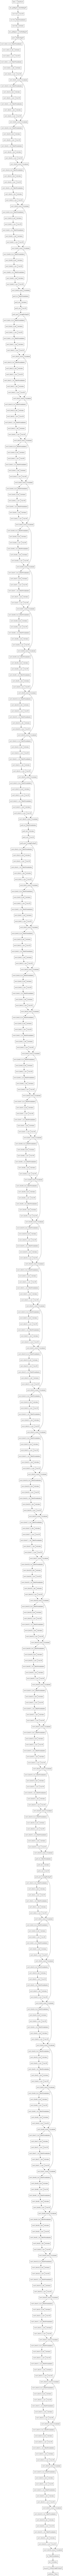

In [ ]:
keras.utils.plot_model(model)

Scelgo dove tagliare il modello addestrare su imagenet, si predilige un taglio abbastanza vicino all'output.

In [ ]:
model =tf.keras.applications.DenseNet121(weights='imagenet', include_top=True, input_shape=(224,224,3))
model=keras.Model(inputs=model.input,
            outputs= model.get_layer('conv5_block16_2_conv').output) 
 
  #model.summary()
for layer in model.layers:
    layer.trainable = False  


Layer aggiunti alla rete

In [ ]:
from keras.models import Sequential
from tensorflow.keras import regularizers

prova = Sequential()
prova.add(keras.Input(shape=(224,224,3)))

prova.add(keras.layers.RandomFlip("horizontal"))
prova.add(keras.layers.RandomRotation(0.3, fill_mode="nearest"))
prova.add(keras.layers.RandomZoom(0.5))
prova.add(keras.layers.RandomContrast(0.5))
prova.add(keras.layers.RandomTranslation(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2)))

#prova.add(keras.applications.densenet.preprocess_input)

prova.add(keras.layers.Rescaling(scale=1./255.0))

prova.add(model)

prova.add(keras.layers.MaxPooling2D((2, 2)))
prova.add(keras.layers.Conv2D(320, (3, 3), padding = "same", activation='relu'))


prova.add(keras.layers.Flatten())
prova.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
#, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
#, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)
prova.add(keras.layers.Dropout(0.4))
prova.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(10, activation='softmax'))
prova.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                        

## Training del modello

In [ ]:
prova.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prova.fit(X_train_nuovo, y_train_nuovo,
          epochs=50, batch_size=64,
          validation_split = 0.2
        );


Epoch 1/50
56/56 [==============================] - 54s 577ms/step - loss: 8.3663 - accuracy: 0.1435 - val_loss: 2.5666 - val_accuracy: 0.2200
Epoch 2/50
56/56 [==============================] - 26s 459ms/step - loss: 2.3075 - accuracy: 0.1962 - val_loss: 2.0660 - val_accuracy: 0.2065
Epoch 3/50
56/56 [==============================] - 26s 464ms/step - loss: 2.1138 - accuracy: 0.2016 - val_loss: 2.0227 - val_accuracy: 0.2435
Epoch 4/50
56/56 [==============================] - 26s 460ms/step - loss: 2.0587 - accuracy: 0.2089 - val_loss: 2.0411 - val_accuracy: 0.2256
Epoch 5/50
56/56 [==============================] - 26s 461ms/step - loss: 2.0565 - accuracy: 0.2136 - val_loss: 1.8902 - val_accuracy: 0.2492
Epoch 6/50
56/56 [==============================] - 26s 461ms/step - loss: 2.0081 - accuracy: 0.2496 - val_loss: 1.8134 - val_accuracy: 0.3345
Epoch 7/50
56/56 [==============================] - 26s 461ms/step - loss: 1.9433 - accuracy: 0.2953 - val_loss: 1.7448 - val_accuracy: 0.3524

In [ ]:
from matplotlib import pyplot as plt
x_plot = list(range(1,50+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss']) 
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(network_history)

## Validazione del modello

In [ ]:
#accuracy sui dati di test
score1 = prova.evaluate(X_test_nuovo, y_test_nuovo)
score1

35/35 [==============================] - 11s 251ms/step - loss: 1.4099 - accuracy: 0.5655


[1.4098931550979614, 0.5655296444892883]

In [ ]:
prova.save('dense.h5') 

In [ ]:
#tempo di inferenza
t0 = time.time()
y_pred = prova.predict(X_test_nuovo)
t = time.time()-t0
print(t)

9.250076532363892


In [ ]:
y = encoder.inverse_transform(np.argmax(y_test_nuovo, axis=1))
y_pred =encoder.inverse_transform(np.argmax(y_pred, axis=1))

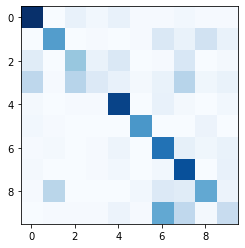

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y, y_pred)   
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
cm

array([[105,   0,   8,   3,   8,   1,   1,   3,   1,   1],
       [  0,  60,   0,   1,   0,   1,  15,   7,  20,   7],
       [ 12,   0,  41,   7,  15,   0,   1,  16,   0,   2],
       [ 29,   1,  31,  14,   8,   2,   7,  31,   4,   7],
       [  2,   0,   1,   1,  97,   0,   8,   2,   0,   3],
       [  3,   1,   0,   0,   0,  63,   0,   0,   6,   0],
       [  1,   2,   0,   1,   5,   0,  78,   9,   4,   7],
       [  2,   0,   0,   1,   3,   0,   3,  92,   0,   8],
       [  1,  30,   0,   0,   0,   3,  14,  12,  55,   6],
       [  0,   1,   1,   1,   6,   1,  55,  28,   2,  25]])

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         dew       0.68      0.80      0.73       131
     fogsmog       0.63      0.54      0.58       111
       frost       0.50      0.44      0.47        94
       glaze       0.48      0.10      0.17       134
        hail       0.68      0.85      0.76       114
   lightning       0.89      0.86      0.88        73
        rain       0.43      0.73      0.54       107
        rime       0.46      0.84      0.60       109
   sandstorm       0.60      0.45      0.52       121
        snow       0.38      0.21      0.27       120

    accuracy                           0.57      1114
   macro avg       0.57      0.58      0.55      1114
weighted avg       0.56      0.57      0.53      1114

